In [56]:
from google.colab import files
uploaded = files.upload()



Saving example.png to example.png


In [57]:
! ls

example.png  generated_images  sample_data


# Breaking CAPTCHA’s Using Deep Learning

In [7]:
from random import choice
from captcha.image import ImageCaptcha
import os.path
from os import makedirs


In [8]:
# create constant's 

CAPTCHA_FOLDER = 'generated_images'
LETTERS_FOLDER = 'letters'

CHARACTERS = list('QWERTPASDFGHKLZXBNM')
NR_CAPTCHAS = 1000
NR_CHARACTERS = 4

MODEL_FILE = 'model.hdf5'
LABELS_FILE = 'labels.dat'

MODEL_SHAPE = (100, 100)


In [10]:
! ls

generated_images  sample_data


In [80]:
# generates captcha images
try:
  makedirs(CAPTCHA_FOLDER)
except:
  print("Present already")  

image = ImageCaptcha()

for i in range(NR_CAPTCHAS):
    captcha = ''.join([choice(CHARACTERS) for c in range(NR_CHARACTERS)])
    filename = os.path.join(CAPTCHA_FOLDER, '{}_{}.png'.format(captcha, i))
    image.write(captcha, filename)
    print('Generated:', captcha)
    

Present already
Generated: GAAS
Generated: GDHA
Generated: EQQL
Generated: KZFL
Generated: TMXA
Generated: RQNH
Generated: AKHH
Generated: DBZM
Generated: AXSK
Generated: AQXE
Generated: EXDB
Generated: TMWS
Generated: LNLB
Generated: PHBE
Generated: TXXL
Generated: SAZQ
Generated: BAQN
Generated: WNTZ
Generated: BQSX
Generated: RESG
Generated: DSAW
Generated: FHRD
Generated: BQFQ
Generated: MNRL
Generated: BKLF
Generated: LKNM
Generated: ADDB
Generated: NNLW
Generated: PLRR
Generated: TSBD
Generated: PQPE
Generated: RXGF
Generated: RZZS
Generated: XNMK
Generated: BSQE
Generated: XSLM
Generated: GMTQ
Generated: MQTL
Generated: WXTL
Generated: MPSN
Generated: MTGW
Generated: FHKR
Generated: XTED
Generated: MMLR
Generated: FZRP
Generated: RZFB
Generated: XEZR
Generated: RQRX
Generated: PGBD
Generated: ZADZ
Generated: HTFR
Generated: XDPW
Generated: RKXG
Generated: TRKQ
Generated: NTNN
Generated: FWPD
Generated: SDRL
Generated: NGAZ
Generated: QPRD
Generated: DRGZ
Generated: BLXQ
Generate

## thresholding, opening, and contour detection 

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

width:160
height: 60
channels: 3


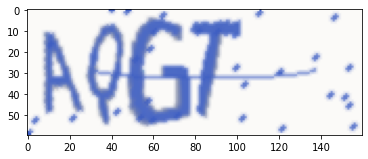

In [58]:
image_file = 'example.png'
image = cv2.imread(image_file)
print(f"width:{image.shape[1]}")
print(f"height: {image.shape[0]}")
print(f"channels: {image.shape[2]}")

plt.imshow(image,cmap='gray')




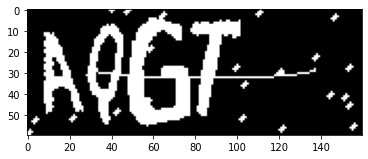

In [59]:
# Convert to grayscale, followed by thresholding to black and white
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.imshow( thresh, cmap='gray')

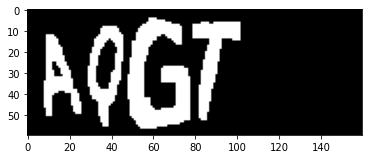

In [60]:
# Apply opening: "erosion" followed by "dilation"
denoised = thresh.copy()
kernel = np.ones((4, 3), np.uint8)
denoised = cv2.erode(denoised, kernel, iterations=1)
kernel = np.ones((6, 3), np.uint8)
denoised = cv2.dilate(denoised, kernel, iterations=1)
plt.imshow( denoised, cmap='gray' )

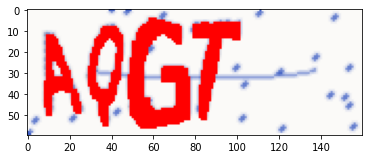

In [61]:
# Now find contours and overlay them over our original image

cnts, _ = cv2.findContours(denoised.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(image, cnts, contourIdx=-1, color=(255, 0, 0), thickness=-1)

plt.imshow( image, cmap='gray')

# We now still need a way to use the contours to create separate images : one per character. 

In [62]:
# Perform thresholding, erosion and contour finding as shown before
image = cv2.imread(image_file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

denoised = thresh.copy()
kernel = np.ones((4, 3), np.uint8)
denoised = cv2.erode(denoised, kernel, iterations=1)
kernel = np.ones((6, 3), np.uint8)
denoised = cv2.dilate(denoised, kernel, iterations=1)
cnts, _ = cv2.findContours(denoised.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)


In [63]:
# Create a fresh 'mask' image
mask = np.ones((image.shape[0], image.shape[1]), dtype="uint8") * 0
# We'll use the first contour as an example
contour = cnts[0]
# Draw this contour over the mask
cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

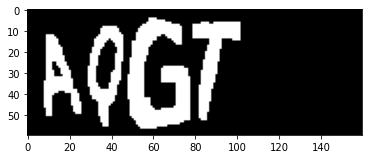

In [64]:
# Denoised Image

plt.imshow( denoised, cmap='gray' )



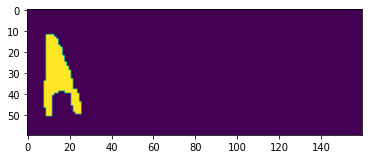

In [65]:
# Mask after drawing contour

plt.imshow( mask )

In [66]:
result = cv2.bitwise_and(denoised, mask)

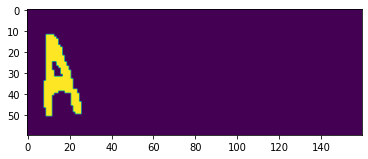

In [67]:
# Result after AND  operation

plt.imshow(result)

-1

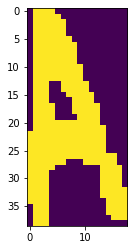

In [68]:
retain = result > 0
result = result[np.ix_(retain.any(1), retain.any(0))]

plt.imshow(result)
cv2.waitKey(0)

In [69]:
# We’ll put all of this in a separate list of functions

In [70]:
from math import ceil, floor

In [71]:
def overlaps(contour1, contour2, threshold=0.8):
    # Check whether two contours' bounding boxes overlap
    area1 = contour1['w'] * contour1['h']
    area2 = contour2['w'] * contour2['h']
    left = max(contour1['x'], contour2['x'])
    right = min(contour1['x'] + contour1['w'], contour2['x'] + contour2['w'])
    top = max(contour1['y'], contour2['y'])
    bottom = min(contour1['y'] + contour1['h'], contour2['y'] + contour2['h'])
    if left <= right and bottom >= top:
        intArea = (right - left) * (bottom - top)
        intRatio = intArea / min(area1, area2)
        if intRatio >= threshold:
            # Return True if the second contour is larger
            return area2 > area1
    # Don't overlap or doesn't exceed threshold
    return None
    

In [72]:
def remove_overlaps(cnts):
    contours = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        new_contour = {'x': x, 'y': y, 'w': w, 'h': h, 'c': c}
        for other_contour in contours:
            overlap = overlaps(other_contour, new_contour)
            if overlap is not None:
                if overlap:
                    # Keep this one...
                    contours.remove(other_contour)
                    contours.append(new_contour)
                # ... otherwise do nothing: keep the original one
                break
        else:
            # We didn't break, so no overlap found, add the contour
            contours.append(new_contour)
    return contours


In [73]:
def process_image(image):
    # Perform basic pre-processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    denoised = thresh.copy()
    kernel = np.ones((4, 3), np.uint8)
    denoised = cv2.erode(denoised, kernel, iterations=1)
    kernel = np.ones((6, 3), np.uint8)
    denoised = cv2.dilate(denoised, kernel, iterations=1)
    return denoised

In [82]:
def get_contours(image):
    # Retrieve contours
    cnts, _ = cv2.findContours(image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # Remove overlapping contours
    contours = remove_overlaps(cnts)
    # Sort by size, keep only the first NR_CHARACTERS
    contours = sorted(contours, key=lambda x: x['w'] * x['h'],
                      reverse=True)[:NR_CHARACTERS]
    # Sort from left to right
    contours = sorted(contours, key=lambda x: x['x'], reverse=False)
    return contours


In [76]:
def extract_contour(image, contour, desired_width, threshold=1.7):
    mask = np.ones((image.shape[0], image.shape[1]), dtype="uint8") * 0
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1)
    result = cv2.bitwise_and(image, mask)
    mask = result > 0
    result = result[np.ix_(mask.any(1), mask.any(0))]

    if result.shape[1] > desired_width * threshold:
      # This contour is wider than expected, split it
      amount = ceil(result.shape[1] / desired_width)
      each_width = floor(result.shape[1] / amount)
      # Note: indexing based on im[y1:y2, x1:x2]
      results = [result[0:(result.shape[0] - 1),
                        (i * each_width):((i + 1) * each_width - 1)] \
                  for i in range(amount)]
      return results
    return [result]


In [77]:

def get_letters(image, contours):
    desired_size = (contours[-1]['x'] + contours[-1]['w'] - contours[0]['x']) \
                    / NR_CHARACTERS
    masks = [m for l in [extract_contour(image, contour['c'], desired_size) \
             for contour in contours] for m in l]
    return masks
    

In [78]:
from os import makedirs
import os.path
from glob import glob


In [83]:
# will write cutting script;

image_files = glob(os.path.join(CAPTCHA_FOLDER, '*.png'))

for image_file in image_files:
    print('Now doing file:', image_file)
    answer = os.path.basename(image_file).split('_')[0]
    image = cv2.imread(image_file)
    processed = process_image(image)
    contours = get_contours(processed)
    if not len(contours):
        print('[!] Could not extract contours')
        continue
    letters = get_letters(processed, contours)
    if len(letters) != NR_CHARACTERS:
        print('[!] Could not extract desired amount of characters')
        continue
    if any([l.shape[0] < 10 or l.shape[1] < 10 for l in letters]):
        print('[!] Some of the extracted characters are too small')
        continue
    for i, mask in enumerate(letters):
        letter = answer[i]
        outfile = '{}_{}.png'.format(answer, i)
        outpath = os.path.join(LETTERS_FOLDER, letter)
        if not os.path.exists(outpath):
            makedirs(outpath)
        print('[i] Saving', letter, 'as', outfile)
        cv2.imwrite(os.path.join(outpath, outfile), mask)
        

Streaming output truncated to the last 5000 lines.
[i] Saving L as HWBL_3.png
Now doing file: generated_images/WWAW_582.png
[!] Could not extract desired amount of characters
Now doing file: generated_images/SNAF_520.png
[i] Saving S as SNAF_0.png
[i] Saving N as SNAF_1.png
[i] Saving A as SNAF_2.png
[i] Saving F as SNAF_3.png
Now doing file: generated_images/QKAX_716.png
[!] Could not extract desired amount of characters
Now doing file: generated_images/RZWH_558.png
[!] Could not extract desired amount of characters
Now doing file: generated_images/APZF_637.png
[i] Saving A as APZF_0.png
[i] Saving P as APZF_1.png
[i] Saving Z as APZF_2.png
[i] Saving F as APZF_3.png
Now doing file: generated_images/MBAR_715.png
[!] Could not extract desired amount of characters
Now doing file: generated_images/DLHP_540.png
[!] Could not extract desired amount of characters
Now doing file: generated_images/DZGS_292.png
[i] Saving D as DZGS_0.png
[i] Saving Z as DZGS_1.png
[i] Saving G as DZGS_2.png
[i

In [85]:
! cd letters && ls

A  B  D  E  F  G  H  K	L  M  N  P  Q  R  S  T	W  X  Z


In [86]:
# so, letter directory contains a directory for each letter

In [87]:
import keras

In [88]:
# lets train the model

In [89]:
import cv2
import pickle
from os import listdir
import os.path
import numpy as np
from glob import glob
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense


In [90]:
data = []
labels = []
nr_labels = len(listdir(LETTERS_FOLDER))


In [91]:
# Convert each image to a data matrix
for label in listdir(LETTERS_FOLDER):
    for image_file in glob(os.path.join(LETTERS_FOLDER, label, '*.png')):
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize the image so all images have the same input shape
        image = cv2.resize(image, MODEL_SHAPE)
        # Expand dimensions to make Keras happy
        image = np.expand_dims(image, axis=2)
        data.append(image)
        labels.append(label)

In [92]:
# Normalize the data so every value lies between zero and one
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)


In [93]:
# Create a training-test split
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

In [94]:
# Binarize the labels
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)


In [95]:
# Save the binarization for later
with open(LABELS_FILE, "wb") as f:
    pickle.dump(lb, f)

In [96]:
# Construct the model architecture
model = Sequential()
model.add(Conv2D(20, (5, 5), padding="same",
          input_shape=(MODEL_SHAPE[0], MODEL_SHAPE[1], 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(500, activation="relu"))
model.add(Dense(nr_labels, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [97]:
# Train and save the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=1)
model.save(MODEL_FILE)

Epoch 1/10
101/101 [==============================] - 65s 647ms/step - loss: 0.8759 - accuracy: 0.7698 - val_loss: 0.3354 - val_accuracy: 0.9199
Epoch 2/10
101/101 [==============================] - 63s 624ms/step - loss: 0.1559 - accuracy: 0.9599 - val_loss: 0.2996 - val_accuracy: 0.9282
Epoch 3/10
101/101 [==============================] - 63s 621ms/step - loss: 0.0440 - accuracy: 0.9873 - val_loss: 0.3383 - val_accuracy: 0.9273
Epoch 4/10
101/101 [==============================] - 63s 620ms/step - loss: 0.0136 - accuracy: 0.9966 - val_loss: 0.4473 - val_accuracy: 0.9171
Epoch 5/10
101/101 [==============================] - 63s 621ms/step - loss: 0.0194 - accuracy: 0.9947 - val_loss: 0.4346 - val_accuracy: 0.9320
Epoch 6/10
101/101 [==============================] - 63s 623ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.4471 - val_accuracy: 0.9366
Epoch 7/10
101/101 [==============================] - 63s 622ms/step - loss: 0.0187 - accuracy: 0.9963 - val_loss: 0.3756 - val_ac

In [98]:
# Let's Apply

In [99]:
from keras.models import load_model
import pickle
import os.path
from glob import glob
from random import choice


In [100]:
! ls

example.png  generated_images  labels.dat  letters  model.hdf5	sample_data


In [101]:
with open(LABELS_FILE, "rb") as f:
    lb = pickle.load(f)
    

In [102]:
model = load_model(MODEL_FILE)

In [107]:
# We simply pick a random training image here to illustrate how predictions work.

image_files = list(glob(os.path.join(CAPTCHA_FOLDER, '*.png')))

image_file = choice(image_files)

print('Testing:', image_file)

Testing: generated_images/LZAF_725.png


In [108]:
image = cv2.imread(image_file)
image = process_image(image)
contours = get_contours(image)
letters = get_letters(image, contours)


In [109]:
for letter in letters:
    letter = cv2.resize(letter, MODEL_SHAPE)
    letter = np.expand_dims(letter, axis=2)
    letter = np.expand_dims(letter, axis=0)
    prediction = model.predict(letter)
    predicted = lb.inverse_transform(prediction)[0]
    print(predicted)

L
Z
A
F
